## **Clasificación técnica mediante SVM, Árboles de Decisión y Random Forest**

### **Autor: Julio Encalada Cuenca**

### **Objetivo General**

Desarrollar, entrenar y comparar clasificadores supervisados usando SVM, Árboles de Decisión y Random Forest para predecir si un cliente realizará una compra o no, basándose en características como edad y salario estimado.

In [18]:
# Se importan las bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier



## **1. Carga del dataset**

In [3]:
# Se carga el dataset
file_path = "Social_Network_Ads.csv"
df = pd.read_csv(file_path)

## **2. Análisis exploratorio de datos**

Dimensiones: (400, 5)

Primeras filas:


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB

Valores nulos:
User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

Distribución de clases (Purchased):
Purchased
0    257
1    143
Name: count, dtype: int64

Proporción (%):
Purchased
0    64.25
1    35.75
Name: proportion, dtype: float64

Estadísticas descriptivas:


,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


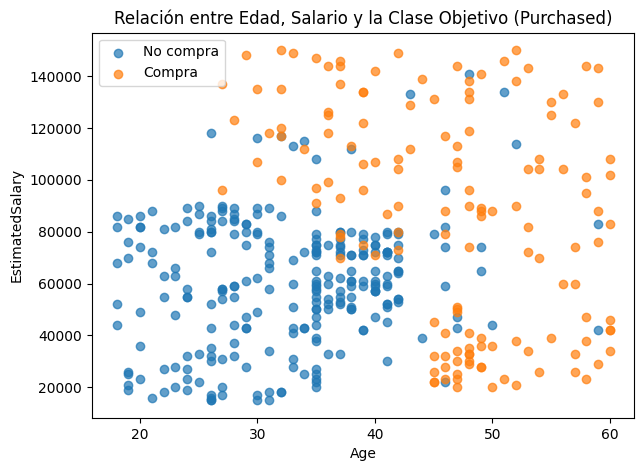

In [5]:
# Exploración inicial del dataset
print("Dimensiones:", df.shape)

print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores nulos:")
print(df.isnull().sum())

print("\nDistribución de clases (Purchased):")
print(df["Purchased"].value_counts())
print("\nProporción (%):")
print(df["Purchased"].value_counts(normalize=True) * 100)

print("\nEstadísticas descriptivas:")
display(df.describe())

plt.figure(figsize=(7,5))

for clase in [0, 1]:
    subset = df[df["Purchased"] == clase]

    etiqueta = "No compra" if clase == 0 else "Compra"

    plt.scatter(
        subset["Age"],
        subset["EstimatedSalary"],
        label=etiqueta,
        alpha=0.7
    )


plt.title("Relación entre Edad, Salario y la Clase Objetivo (Purchased)")
plt.xlabel("Age")
plt.ylabel("EstimatedSalary")
plt.legend()
plt.show()


El diagrama de dispersión muestra que los usuarios de mayor edad y con mayores ingresos presentan una mayor probabilidad de compra, mientras que los usuarios más jóvenes tienden a no realizar compras. No obstante, existe una zona de solapamiento entre ambas clases, lo que justifica el uso de modelos supervisados para mejorar la separación.

In [7]:
# Categorización de edad por rangos

df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[18, 30, 40, 50, 60],
    labels=["18-30", "31-40", "41-50", "51-60"]
)

df.groupby("AgeGroup")["Purchased"].mean()*100


/tmp/ipython-input-2313374289.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("AgeGroup")["Purchased"].mean()*100


,Purchased
AgeGroup,
18-30,5.660377
31-40,23.239437
41-50,60.204082
51-60,91.836735


La segmentación por rangos de edad muestra un incremento progresivo en la tasa de compra.
Los usuarios entre 51 y 60 años presentan la mayor probabilidad de adquisición, mientras
que el grupo de 18 a 30 años muestra una participación mínima.
Esto confirma la relevancia de la edad como variable predictora.

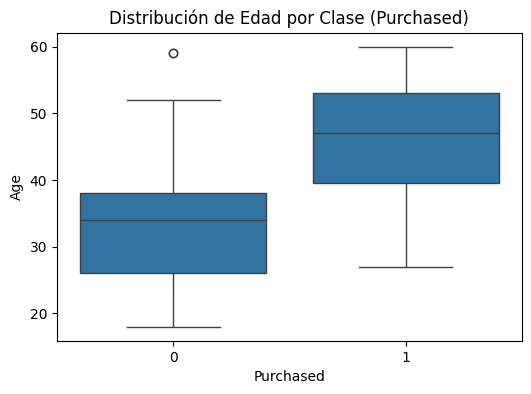

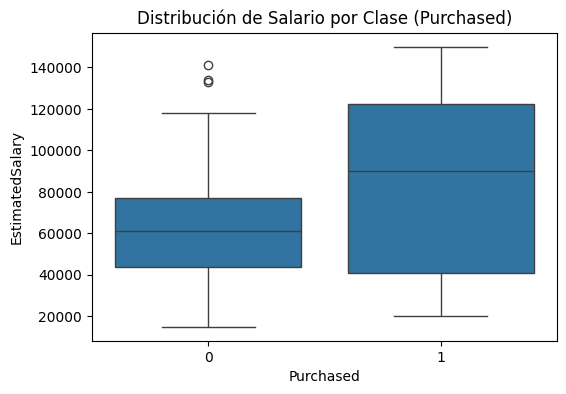

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Purchased", y="Age", data=df)
plt.title("Distribución de Edad por Clase (Purchased)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="Purchased", y="EstimatedSalary", data=df)
plt.title("Distribución de Salario por Clase (Purchased)")
plt.show()


El boxplot de edad muestra que los usuarios que realizaron compras presentan una mediana de edad mayor que aquellos que no compraron, lo que indica que la edad influye significativamente en la probabilidad de compra.

El boxplot de salario estimado indica que los usuarios que realizaron compras tienden a presentar mayores ingresos que aquellos que no compraron, aunque existe solapamiento entre ambas clases.

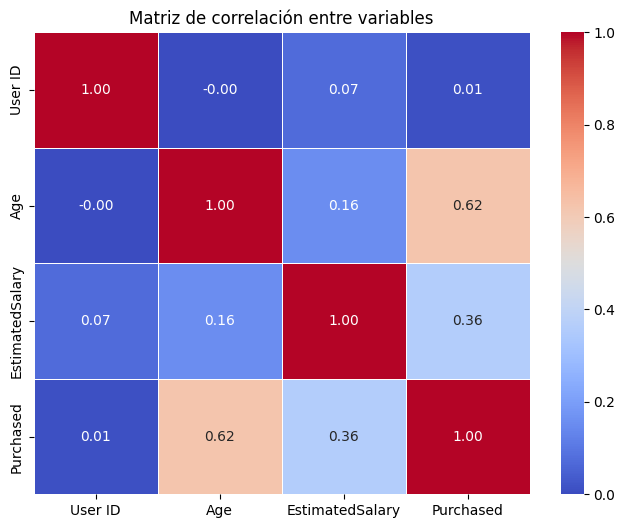

In [9]:
# Análisis de correlación entre variables numéricas

plt.figure(figsize=(8,6))

numeric_df = df.select_dtypes(include=["int64", "float64"])
correlation = numeric_df.corr()

sns.heatmap(
    correlation,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Matriz de correlación entre variables")
plt.show()


La matriz de correlación muestra que la variable Age presenta una relación positiva moderada con la variable objetivo Purchased (r ≈ 0.62), lo que sugiere que a mayor edad existe una mayor probabilidad de compra.

Por otro lado, EstimatedSalary presenta una correlación positiva más débil con Purchased (r ≈ 0.36), indicando que el salario influye en menor medida en la decisión de compra.

La variable User ID no muestra relación significativa con la variable objetivo, por lo que se considera irrelevante para el proceso de clasificación.

Asimismo, la relación entre Age y EstimatedSalary es baja (r ≈ 0.16), lo que indica una baja multicolinealidad entre las variables predictoras.

## **3. Preprocesamiento**

En esta etapa se realizó la selección y transformación de variables relevantes para el modelado. Se eliminó el identificador del usuario por no aportar información predictiva y se transformó la variable categórica Gender a formato numérico cuando estuvo disponible.

In [10]:
# 3. Preprocesamiento
# Eliminamos columnas que no vamos a utilizar (si el dataset contiene 'User ID' y 'Gender')
if 'User ID' in df.columns:
    df = df.drop('User ID', axis=1)

# Si existe la columna 'Gender', la convertimos en numérica para poder usarla como característica
if 'Gender' in df.columns:
    # Convertimos 'Gender' a variable numérica (0: Female, 1: Male)
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    # Selección de características incluyendo 'Gender'
    X = df[['Gender', 'Age', 'EstimatedSalary']]
else:
    # Si no hay columna Gender, usamos solo Age y EstimatedSalary
    X = df[['Age', 'EstimatedSalary']]

y = df['Purchased']


Posteriormente, los datos fueron divididos en conjuntos de entrenamiento y prueba (80/20), garantizando la proporcionalidad de las clases mediante stratify. Finalmente, se aplicó escalado estándar para normalizar las variables y evitar sesgos en los modelos basados en distancia.

In [13]:
#
# División en entrenamiento y prueba (80/20)
#
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (320, 3)
Tamaño del conjunto de prueba: (80, 3)


## **4. Implementación de clasificadores**

Entrenar y evaluar:
- Modelo 1: SVM (con ajuste de kernel y C)
- Modelo 2: Árbol de decisión
- Modelo 3: Random Forest

## **Implementación de los tres modelos: SVM, Árbol de Decisión y Random Forest**


MODELO 1: SUPPORT VECTOR MACHINE (SVM)

Configuración: {'kernel': 'linear', 'C': 1}

Matriz de Confusión (SVM):
[[47  4]
 [13 16]]


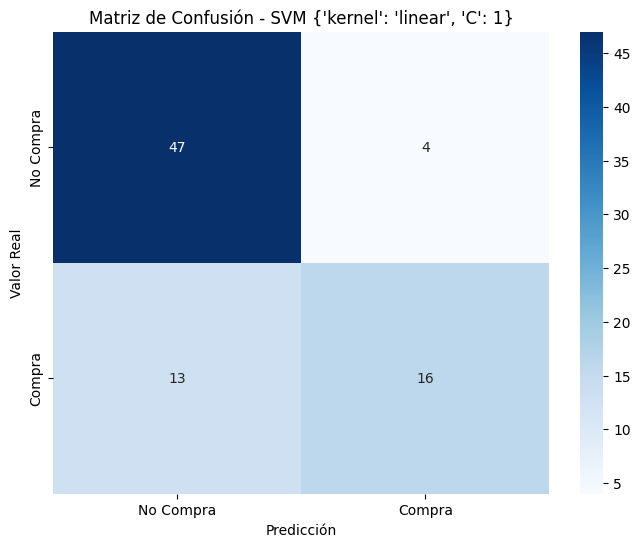


Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.78      0.92      0.85        51
           1       0.80      0.55      0.65        29

    accuracy                           0.79        80
   macro avg       0.79      0.74      0.75        80
weighted avg       0.79      0.79      0.78        80


Configuración: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}

Matriz de Confusión (SVM):
[[46  5]
 [ 2 27]]


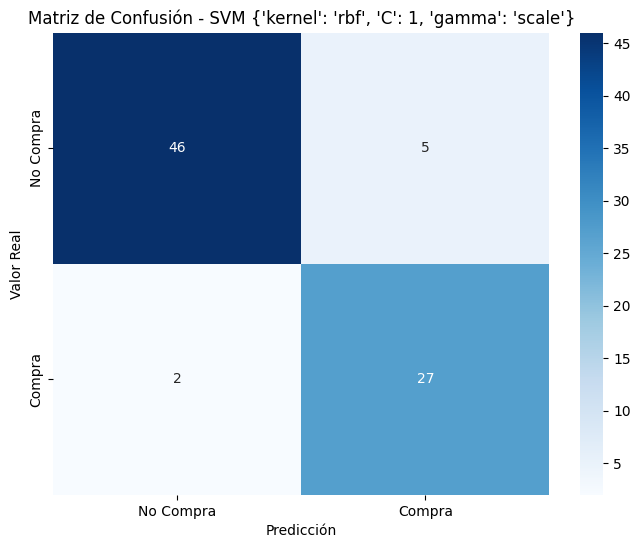


Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        51
           1       0.84      0.93      0.89        29

    accuracy                           0.91        80
   macro avg       0.90      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80


Configuración: {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}

Matriz de Confusión (SVM):
[[46  5]
 [ 3 26]]


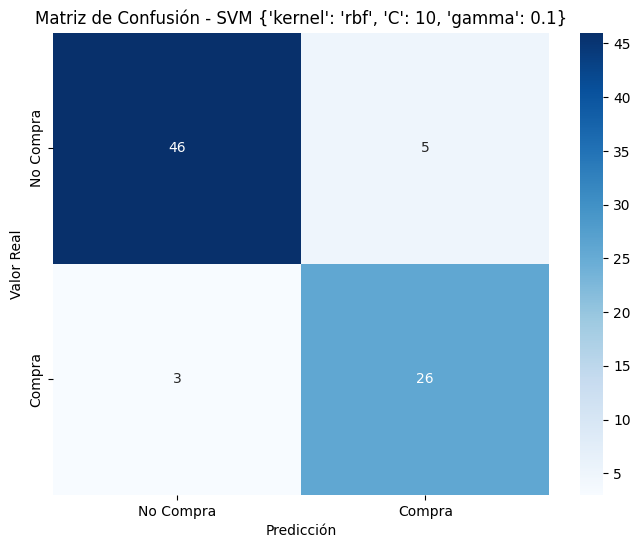


Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        51
           1       0.84      0.90      0.87        29

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80



In [14]:
# --------------------------------------------------
# Implementación de MODELO 1: SUPPORT VECTOR MACHINE (SVM)
# --------------------------------------------------

print("\n" + "="*50)
print("MODELO 1: SUPPORT VECTOR MACHINE (SVM)")
print("="*50)

# Configuraciones a evaluar
configs_svm = [
    {'kernel':'linear', 'C':1},
    {'kernel':'rbf', 'C':1, 'gamma':'scale'},
    {'kernel':'rbf', 'C':10, 'gamma':0.1}
]

# Evaluación de cada configuración
for cfg in configs_svm:

    print("\nConfiguración:", cfg)

    # Entrenamiento del modelo
    svm = SVC(**cfg, random_state=42)
    svm.fit(X_train, y_train)

    # Predicciones
    y_pred_svm = svm.predict(X_test)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred_svm)
    print("\nMatriz de Confusión (SVM):")
    print(conf_matrix)

    # Visualización
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Compra', 'Compra'],
                yticklabels=['No Compra', 'Compra'])

    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(f"Matriz de Confusión - SVM {cfg}")
    plt.show()

    # Reporte de clasificación
    print("\nReporte de Clasificación (SVM):")
    print(classification_report(y_test, y_pred_svm))


**Interpretación (SVM)**

Se evaluaron dos tipos de kernel (lineal y RBF), considerando distintas configuraciones de hiperparámetros para el kernel RBF. El kernel lineal se probó como línea base por su simplicidad e interpretabilidad, mientras que el kernel RBF se incorporó para capturar relaciones no lineales entre las variables (edad y salario) y la decisión de compra. Adicionalmente, se ajustaron los hiperparámetros C (control de regularización) y gamma (alcance de influencia de los puntos en RBF) para observar su efecto en el equilibrio entre sesgo y varianza.

La mejor configuración fue RBF (C=1, gamma=scale), al obtener el mayor F1-score y recall en la clase “Compra”, alcanzando además una precisión global del 91%. Esto evidencia que dicha configuración ofrece el mejor equilibrio entre precisión, sensibilidad y capacidad de generalización para este problema.


MODELO 2: ÁRBOL DE DECISIÓN

Configuración: {'max_depth': 2}

Matriz de Confusión (Árbol):
[[45  6]
 [ 3 26]]


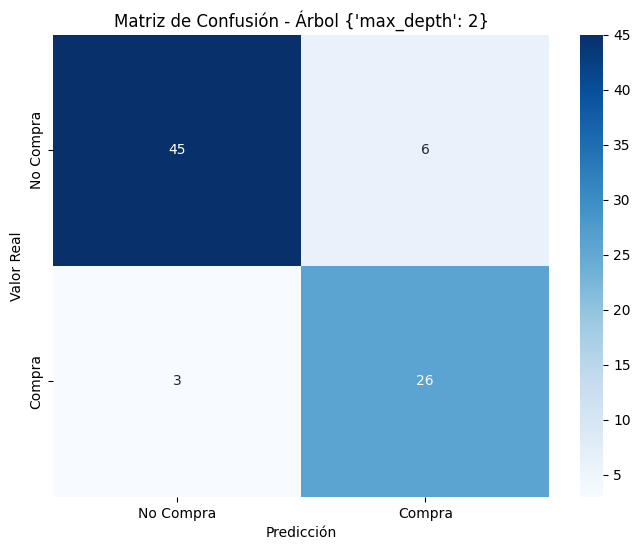


Reporte de Clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        51
           1       0.81      0.90      0.85        29

    accuracy                           0.89        80
   macro avg       0.88      0.89      0.88        80
weighted avg       0.89      0.89      0.89        80


Importancia de características:
Gender: 0.0000
Age: 0.5433
EstimatedSalary: 0.4567

Configuración: {'max_depth': 4}

Matriz de Confusión (Árbol):
[[45  6]
 [ 5 24]]


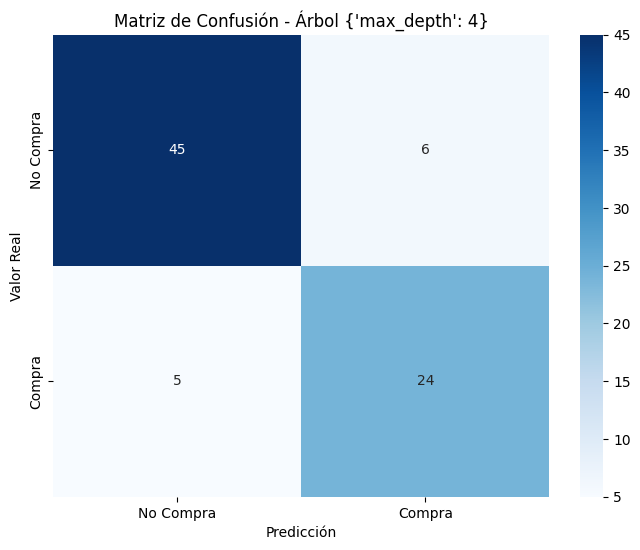


Reporte de Clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        51
           1       0.80      0.83      0.81        29

    accuracy                           0.86        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.86      0.86      0.86        80


Importancia de características:
Gender: 0.0000
Age: 0.5483
EstimatedSalary: 0.4517

Configuración: {'max_depth': 6}

Matriz de Confusión (Árbol):
[[45  6]
 [ 7 22]]


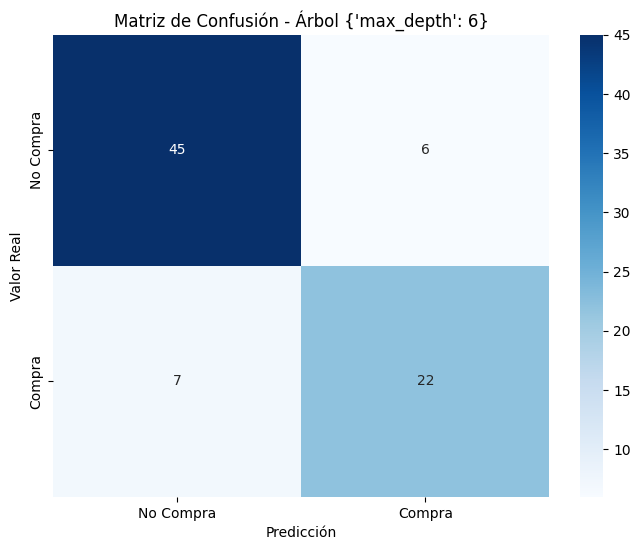


Reporte de Clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        51
           1       0.79      0.76      0.77        29

    accuracy                           0.84        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.84      0.84      0.84        80


Importancia de características:
Gender: 0.0056
Age: 0.5213
EstimatedSalary: 0.4731


In [16]:
# --------------------------------------------------
# Implementación de MODELO 2: Árbol de Decisión
# --------------------------------------------------

print("\n" + "="*50)
print("MODELO 2: ÁRBOL DE DECISIÓN")
print("="*50)

# Configuraciones a evaluar (profundidades del árbol)
configs_tree = [
    {'max_depth': 2},
    {'max_depth': 4},
    {'max_depth': 6}
]

# Evaluación de cada configuración
for cfg in configs_tree:

    print("\nConfiguración:", cfg)

    # Entrenamiento del modelo
    tree = DecisionTreeClassifier(**cfg, random_state=42)
    tree.fit(X_train, y_train)

    # Predicciones
    y_pred_tree = tree.predict(X_test)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred_tree)
    print("\nMatriz de Confusión (Árbol):")
    print(conf_matrix)

    # Visualización
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Compra', 'Compra'],
                yticklabels=['No Compra', 'Compra'])

    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(f"Matriz de Confusión - Árbol {cfg}")
    plt.show()

    # Reporte de clasificación
    print("\nReporte de Clasificación (Árbol de Decisión):")
    print(classification_report(y_test, y_pred_tree, zero_division=0))


    # Importancia de características
    print("\nImportancia de características:")
    for col, imp in zip(X.columns, tree.feature_importances_):
        print(f"{col}: {imp:.4f}")



**Interpretación (Árbol de Decisión)**

En el modelo Árbol de Decisión se evaluaron distintas profundidades máximas (2, 4 y 6) con el fin de controlar el sobreajuste. Los resultados evidencian que una profundidad reducida (max_depth = 2) ofrece el mejor equilibrio entre precisión y capacidad de generalización, alcanzando un accuracy del 89% y un F1-score de 0.85 en la clase “Compra”. A medida que aumenta la profundidad, el modelo pierde capacidad predictiva, lo que indica la presencia de sobreajuste.

Asimismo, el análisis de importancia de características muestra que la edad es el principal predictor del comportamiento de compra, seguida del salario estimado, mientras que el género presenta una contribución marginal.


MODELO 3: RANDOM FOREST

Configuración: {'n_estimators': 100, 'max_depth': 5}

Matriz de Confusión (Random Forest):
[[46  5]
 [ 3 26]]


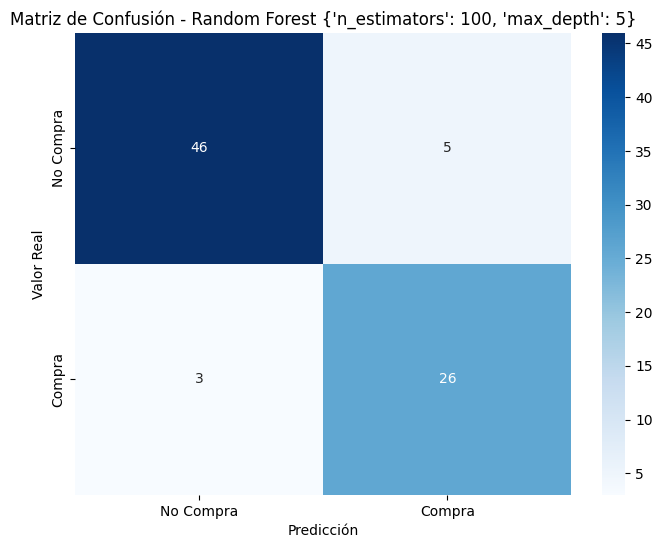


Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        51
           1       0.84      0.90      0.87        29

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80


Importancia de características:
Gender: 0.0084
Age: 0.5327
EstimatedSalary: 0.4589

Configuración: {'n_estimators': 200, 'max_depth': None}

Matriz de Confusión (Random Forest):
[[46  5]
 [ 3 26]]


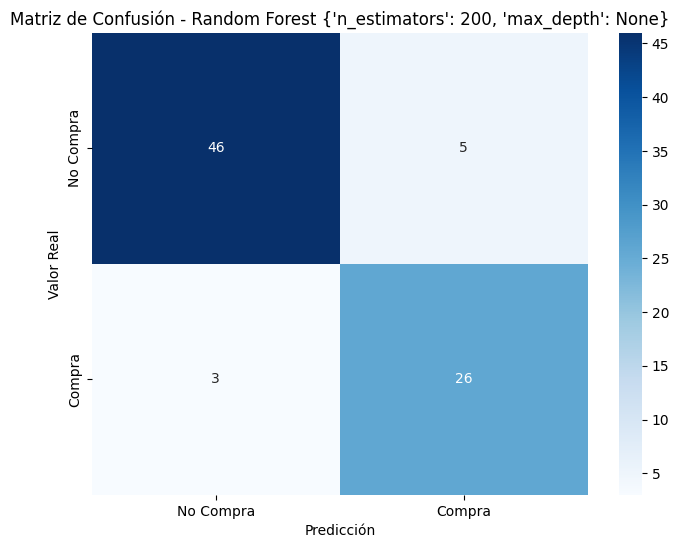


Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        51
           1       0.84      0.90      0.87        29

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80


Importancia de características:
Gender: 0.0094
Age: 0.4947
EstimatedSalary: 0.4959

Configuración: {'n_estimators': 300, 'max_depth': None}

Matriz de Confusión (Random Forest):
[[46  5]
 [ 3 26]]


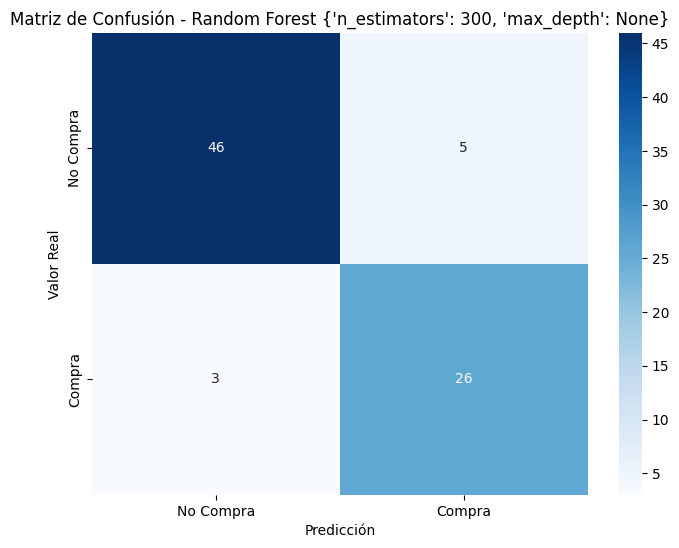


Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        51
           1       0.84      0.90      0.87        29

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80


Importancia de características:
Gender: 0.0089
Age: 0.4974
EstimatedSalary: 0.4937


In [19]:
# --------------------------------------------------
# Implementación de MODELO 3: Random Forest
# --------------------------------------------------

print("\n" + "="*50)
print("MODELO 3: RANDOM FOREST")
print("="*50)

# Configuraciones a evaluar
configs_rf = [
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 200, 'max_depth': None},
    {'n_estimators': 300, 'max_depth': None}
]

# Evaluación de cada configuración
for cfg in configs_rf:

    print("\nConfiguración:", cfg)

    # Entrenamiento del modelo
    rf = RandomForestClassifier(**cfg, random_state=42)
    rf.fit(X_train, y_train)

    # Predicciones
    y_pred_rf = rf.predict(X_test)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred_rf)
    print("\nMatriz de Confusión (Random Forest):")
    print(conf_matrix)

    # Visualización
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Compra', 'Compra'],
                yticklabels=['No Compra', 'Compra'])

    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(f"Matriz de Confusión - Random Forest {cfg}")
    plt.show()

    # Reporte de clasificación
    print("\nReporte de Clasificación (Random Forest):")
    print(classification_report(y_test, y_pred_rf, zero_division=0))

    # Importancia de características
    print("\nImportancia de características:")
    for col, imp in zip(X.columns, rf.feature_importances_):
        print(f"{col}: {imp:.4f}")

**Interpretación (Random Forest)**

Sobre el modelo Random Forest

En el modelo Random Forest se evaluaron distintas configuraciones variando el número de árboles y la profundidad máxima. Los resultados muestran un desempeño estable en todas las configuraciones, alcanzando un accuracy del 90% y un F1-score de 0.87 en la clase “Compra”. Esto evidencia la capacidad del modelo para generalizar adecuadamente sin verse afectado significativamente por los cambios en los hiperparámetros.

Sobre la importancia de variables

El análisis de importancia de características indica que la edad es el principal predictor del comportamiento de compra, seguida del salario estimado, mientras que el género presenta una influencia mínima.

# **5. Comparación experimental**
**Métricas obligatorias:**  
•	Precisión  
•	Recall  
•	F1-score  
•	Matriz de confusión  
•	Presentar una tabla resumen con los resultados de cada modelo.  
•	Visualizar la comparación con gráficos (barplot o heatmap).  


**5.1. Presentar tabla resumen con los resultados de cada modelo.**  

Para la fase de comparación se fijaron las mejores configuraciones de cada modelo y se reentrenaron bajo las mismas condiciones para garantizar una evaluación homogénea.

In [26]:
# Para la fase de comparación se fijaron las mejores configuraciones de cada modelo
# y se reentrenaron bajo las mismas condiciones para garantizar una evaluación homogénea.

modelos = {
    "SVM (RBF C=1 γ=scale)": SVC(kernel="rbf", C=1, gamma="scale", random_state=42),
    "Árbol (depth=2)": DecisionTreeClassifier(max_depth=2, random_state=42),
    "Random Forest (200, depth=None)": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42),
}

resultados = []
matrices = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Métricas para clase positiva (Compra=1)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    acc  = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    matrices[nombre] = cm

    resultados.append({
        "Modelo": nombre,
        "Accuracy": round(acc, 2),
        "Precisión (Compra=1)": round(prec, 2),
        "Recall (Compra=1)": round(rec, 2),
        "F1-score (Compra=1)": round(f1, 2),
        "TN": cm[0,0], "FP": cm[0,1], "FN": cm[1,0], "TP": cm[1,1]
    })

df_resumen = pd.DataFrame(resultados).sort_values(by="F1-score (Compra=1)", ascending=False)
df_resumen


,Modelo,Accuracy,Precisión (Compra=1),Recall (Compra=1),F1-score (Compra=1),TN,FP,FN,TP
0,SVM (RBF C=1 γ=scale),0.91,0.84,0.93,0.89,46,5,2,27
2,"Random Forest (200, depth=None)",0.90,0.84,0.90,0.87,46,5,3,26
1,Árbol (depth=2),0.89,0.81,0.90,0.85,45,6,3,26


**Interpretación de tabla comparativa de los tres modelos**  

La comparación experimental muestra que el modelo SVM con kernel RBF obtuvo el mejor desempeño global, alcanzando un accuracy del 91% y un F1-score de 0.89 en la clase “Compra”. Random Forest presentó un rendimiento estable con un F1-score de 0.87, mientras que el Árbol de Decisión, aunque más interpretable, alcanzó un desempeño inferior. En consecuencia, se selecciona el modelo SVM como el más adecuado para la predicción del comportamiento de compra.

Las matrices de confusión fueron analizadas previamente para cada modelo durante la fase experimental. En esta etapa se emplean sus valores para la comparación global, sintetizados en la tabla resumen (comparativa de los tres modelos).

**5.2. Visualizar la comparación con gráficos (barplot o heatmap).**

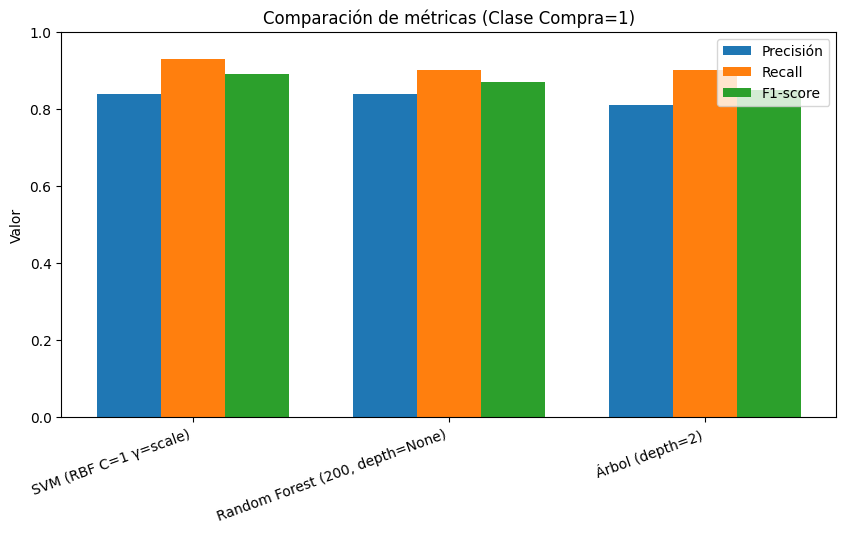

In [23]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ["Precisión (Compra=1)", "Recall (Compra=1)", "F1-score (Compra=1)"]
model_names = df_resumen["Modelo"].tolist()

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, df_resumen[metricas[0]], width, label="Precisión")
plt.bar(x,         df_resumen[metricas[1]], width, label="Recall")
plt.bar(x + width, df_resumen[metricas[2]], width, label="F1-score")

plt.xticks(x, model_names, rotation=20, ha="right")
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.title("Comparación de métricas (Clase Compra=1)")
plt.legend()
plt.show()



**Interpretación del gráfico de comparación de métricas**  

La visualización comparativa de las métricas evidencia que el modelo SVM con kernel RBF presenta el mejor desempeño global en la predicción del comportamiento de compra, al alcanzar los mayores valores de recall y F1-score en la clase “Compra”. Esto indica una mayor capacidad para identificar correctamente a los clientes con intención de adquirir el producto, minimizando la pérdida de compradores potenciales. Aunque el modelo Random Forest muestra un rendimiento estable y competitivo, y el Árbol de Decisión ofrece mayor interpretabilidad, sus resultados son ligeramente inferiores. En consecuencia, se selecciona el modelo SVM como el clasificador más adecuado para este problema, al ofrecer el mejor equilibrio entre precisión, sensibilidad y robustez predictiva.

## **Reflexión técnica y conclusiones**

El presente trabajo permitió desarrollar, entrenar y comparar tres clasificadores supervisados (SVM, Árbol de Decisión y Random Forest) para predecir el comportamiento de compra de los clientes a partir de variables demográficas y económicas. Los resultados evidencian que el modelo SVM con kernel RBF obtuvo el mejor desempeño global, destacándose por su alto recall y F1-score en la clase “Compra”, lo que lo convierte en la alternativa más adecuada para este problema.

Entre los principales hallazgos, se identificó que la edad y el salario estimado constituyen los factores más influyentes en la decisión de compra, mientras que el género presenta una contribución marginal. Asimismo, se observó que los modelos con mayor complejidad, como los árboles de mayor profundidad, tienden a presentar sobreajuste, reduciendo su capacidad de generalización.

No obstante, el estudio presenta ciertas limitaciones. En primer lugar, el conjunto de datos posee un número reducido de variables explicativas, lo que restringe la capacidad predictiva de los modelos. Además, el tamaño muestral es limitado, lo que puede afectar la estabilidad de los resultados. Asimismo, no se aplicaron técnicas avanzadas de validación cruzada ni optimización exhaustiva de hiperparámetros.

Como líneas de mejora futura, se propone incorporar nuevas variables relacionadas con el comportamiento del consumidor, aplicar técnicas de validación cruzada y búsqueda en malla (GridSearchCV), así como explorar modelos más avanzados, como redes neuronales o métodos de ensamble híbridos. Estas acciones permitirían fortalecer la robustez y aplicabilidad del sistema predictivo en entornos reales.

En conclusión, el enfoque implementado demuestra el potencial del aprendizaje supervisado para apoyar la toma de decisiones comerciales, proporcionando información relevante para la identificación temprana de clientes con alta probabilidad de compra.